In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Mean
from model_build import build_unet
from datapreprocess import load_dataset
import matplotlib.pyplot as plt

In [4]:
_, _, (test_x, test_y) = load_dataset("E:/brain_tumor_segmentation/dataset")

In [5]:
input_shape = (256, 256, 3)
model = build_unet(input_shape=input_shape)
model.load_weights("model_best.h5")

In [6]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [10]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    return (mask.astype(np.float32) / 255.0).reshape((256, 256, 1))

In [11]:
loss_fn = lambda y_true, y_pred: 1 - dice_coef(y_true, y_pred)

dice_scores = []
acc_scores = []
losses = []

for img_path, mask_path in zip(test_x, test_y):
    x = np.expand_dims(load_image(img_path), axis=0)
    y_true = np.expand_dims(load_mask(mask_path), axis=0)

    y_pred = model.predict(x, verbose=0)[0]
    y_pred_bin = (y_pred > 0.5).astype(np.float32)

    dice = dice_coef(y_true[0], y_pred_bin).numpy()
    acc = np.mean(y_true[0] == y_pred_bin)
    loss = 1 - dice

    dice_scores.append(dice)
    acc_scores.append(acc)
    losses.append(loss)

In [12]:
print(f"\n✅ Evaluation on test set:")
print(f"   Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"   Accuracy:         {np.mean(acc_scores):.4f}")
print(f"   Dice Loss:        {np.mean(losses):.4f}")


✅ Evaluation on test set:
   Dice Coefficient: 0.6789
   Accuracy:         0.9919
   Dice Loss:        0.3211


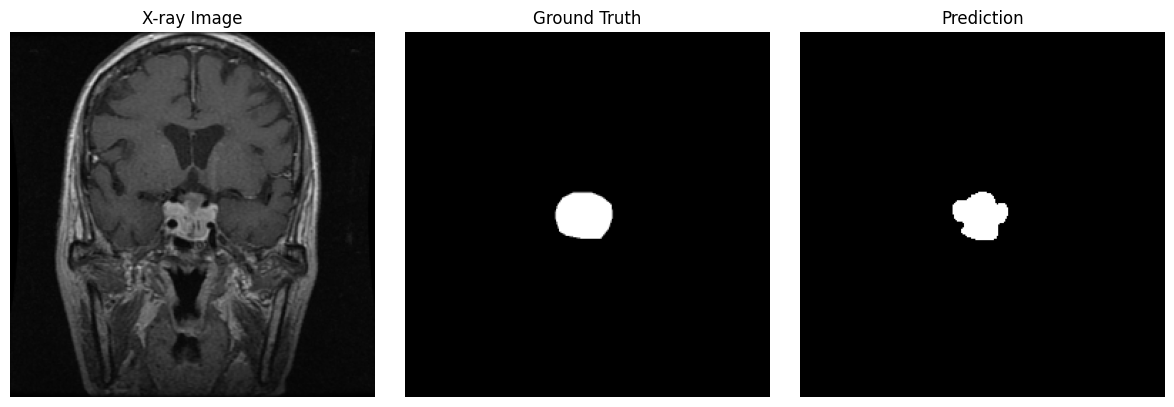

In [19]:
def visualize(idx):
    x_path = test_x[idx]
    y_path = test_y[idx]

    x = load_image(x_path)
    y_true = load_mask(y_path)
    
    y_pred = model.predict(np.expand_dims(x, axis=0), verbose=0)[0]
    y_pred_bin = (y_pred > 0.5).astype(np.float32).squeeze()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(x)
    plt.title("X-ray Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(y_true, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(y_pred_bin, cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize(5)
